In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = [1900 + x*10 for x in range(1, 11)]
y = [92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906]

In [3]:
def getValue(year):
    return y[x.index(year)]

## Интерполяция Ньютона

In [4]:
def newton_coef(x, y):
    n = len(x)
    coef = np.zeros([n, n])
    coef[:, 0] = y
    
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j-1] - coef[i][j - 1]) / (x[i + j] - x[i])

    return coef[0, :]

In [5]:
def polynomial(x, y, points):
    a = newton_coef(x, y)
    n = len(x) - 1

    values = []
    for x0 in points:
        p = a[n]

        for k in range(1, n + 1):
            p = a[n - k] + (x0 - x[n - k]) * p

        values.append(p)

    return values

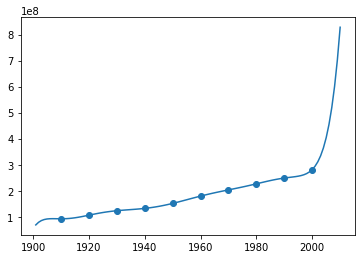

In [6]:
points = [1900 + x for x in range(1, 111)]
plt.plot(points, polynomial(x, y, points))
plt.scatter(x, y)

В 2010 году

In [7]:
print(*polynomial(x, y, [2010]))

827906509.000001


## Кубический сплайн

In [8]:
def solveTriangleSlae(a, b, c, d):
    n = len(b)
    p, q = np.zeros(n), np.zeros(n)
    c = c + [0]
    p[0] = c[0] / b[0]
    q[0] = d[0] / b[0]
    for i in range(1, n):
        j = i - 1
        p[i] = - c[j] / (b[j] + (a[j] * p[j]))
        q[i] = (d[j] - (a[j] * q[j])) / (b[j] + (a[j] * p[j]))

    x = np.zeros(n + 1)

    x[n] = q[-1]
    for i in range(n - 1, 0, -1):
        x[i] = q[i] + (x[i + 1] * p[i])
    return x

In [9]:
class CubicSpline:

    def __init__(self, x, y):
        self.x = np.array(x)
        self.y = np.array(y)
        self.n = len(x)
        self.h = np.diff(x)
        self.h = np.append(self.h, self.h[-1])
        p = self.x.argsort()
        self.x = self.x[p]
        self.y = self.y[p]
        self.a, self.b, self.c, self.d = self.fit()

    def newtonDiff(self, i):
        return (self.y[i] - self.y[i - 1]) / self.h[i]

    def newtonDiff2(self, i):
        return (self.newtonDiff(i) - self.newtonDiff(i - 1)) / (self.h[i] + self.h[i - 1])

    def get_matrix(self):
        a = np.zeros(self.n - 1)
        b = np.zeros(self.n - 1)
        c = np.zeros(self.n - 1)
        d = np.zeros(self.n - 1)
        for i in range(1, self.n - 1):
            j = i - 1
            b[j] = 2
            a[j] = self.h[i] / (self.h[i] + self.h[i + 1])
            c[j] = self.h[i + 1] / (self.h[i + 1] + self.h[i])
            d[j] = 6 * self.newtonDiff2(i + 1)

        return a, b, c, d

    def fit(self):
        am, bm, cm, dm = self.get_matrix()
        N = len(self.x)
        c = solveTriangleSlae(am, bm, cm, dm)
        c = c[:-1]
        a = self.y
        d = np.zeros(N)
        b = np.zeros(N)
        c = np.append(c, 0)
        c = np.append(c, 0)

        for i in range(N - 1, 0, -1):
            d[i] = (c[i] - c[i-1]) / self.h[i]
            b[i] = self.h[i] * (2.0 * c[i] + c[i-1]) / 6.0 + (self.y[i] - self.y[i - 1]) / self.h[i]

        d[0] = c[0] / self.h[0]
        b[0] = self.newtonDiff(1) + (self.h[1] * c[0] / 3)
        return a, b, c, d

    def calculate(self, j, dx):
        return self.a[j] + (self.b[j] * dx) + (self.c[j] * (dx**2) / 2) + (self.d[j] * (dx**3) / 6)

    def interpolate(self, x):
        for i in range(self.n):
            if x <= self.x[i]:
                j = i
                dx = x - self.x[i]
                return self.calculate(j, dx)
        return self.calculate(self.n - 1, x - self.x[self.n - 1])

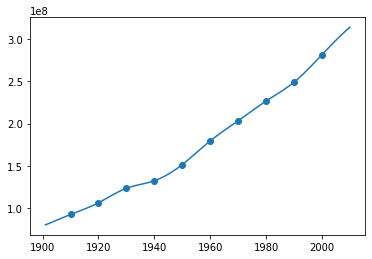

In [10]:
spline = CubicSpline(x, y)

points = [1900 + x for x in range(1, 111)]
plt.plot(points, [spline.interpolate(x) for x in points])
plt.scatter(x, y)

В 2010 году

In [11]:
spline.interpolate(2010)

314133939.0

Точное значение составляет 308 745 человек. Экстраполяция сплайнами намного точнее предсказала результат